The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


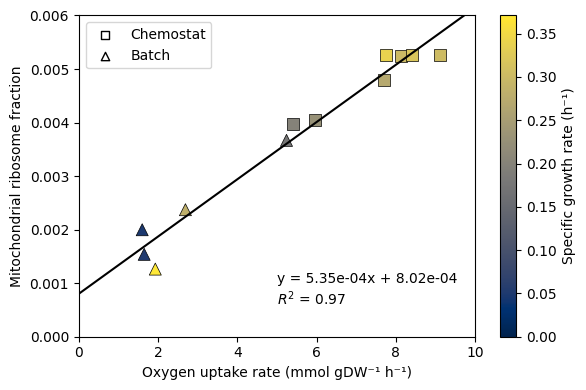

In [1]:
"""
Mitochondrial ribosome content as a proxy for respiration
Francis Mairet (Ifremer Phytox, Nantes, France)
--------------------------------------------------
Supplementary Information – Code for Figures 1–2
--------------------------------------------------
This script processes ribosomal protein abundance data from the
published datasets (Elsemman et al., https://doi.org/10.1038/s41467-022-28467-6). It identifies
cytoplasmic and mitochondrial ribosomal proteins, computes their
total abundance across growth conditions, and generates:

• Figure 1 – Mitochondrial ribosome fraction vs oxygen uptake rate.
• Figure 2 – Cytoplasmic vs mitochondrial ribosome fractions using
  robust RANSAC regression with explicit identification of outliers.
"""
# ============================================================
# 1. Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import linregress
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score

# ============================================================
# 2. Load datasets (from Elsemman et al., https://doi.org/10.1038/s41467-022-28467-6)
# ============================================================

df_prot = pd.read_excel("41467_2022_28467_MOESM8_ESM.xlsx") # List of proteins
df_chemo = pd.read_excel("41467_2022_28467_MOESM5_ESM.xlsx", sheet_name="avgs", na_values=["#N/A"]).fillna(0) # Proteomic data (chemostat)
df_batch = pd.read_excel("41467_2022_28467_MOESM6_ESM.xlsx", sheet_name="avgs", na_values=["#N/A"]).fillna(0) # Proteomic data (batch)

# ============================================================
# 3. Growth conditions (from Elsemman et al., https://doi.org/10.1038/s41467-022-28467-6, ESM4)
# ============================================================

# Growth rates (/h)
mu_chemo = np.array([0.199, 0.227, 0.270, 0.302, 0.300, 0.319, 0.339])
mu_batch = np.array([0.0516, 0.0480, 0.173, 0.283, 0.371])
mu = np.concatenate([mu_chemo, mu_batch])

# Oxygen uptake rates (mmol/gDW/h)
qO2_chemo = np.array([5.41, 5.96, 7.69, 9.11, 8.14, 8.40, 7.75])
qO2_batch = np.array([1.65, 1.60, 5.24, 2.69, 1.93])
qO2 = np.concatenate([qO2_chemo, qO2_batch])

# Oxygen yield coefficients (gDW/mol)
Yield=1000*np.divide(mu , qO2)

# ============================================================
# 4. Extract ribosome protein lists
# ============================================================

prot_ribo = df_prot.loc[df_prot["Pathway"] == "Ribosome", "Protein"].reset_index(drop=True)  # Cytoplasmic ribosome
prot_mito = df_prot.loc[df_prot["Pathway"] == "Mitochondrial ribosome", "Protein"].reset_index(drop=True)  # Mitochondrial ribosome

# ============================================================
# 5. Helper function
# ============================================================

def sum_proteins(df, protein_list, cols):
    """
    Returns the summed abundance for all proteins in a pathway.
    Proteins with all-zero abundance across conditions are excluded.
    """
    subset = df[df["Protein"].isin(protein_list)][cols]
    subset = subset[(subset > 0).any(axis=1)]
    return subset.sum()

# ============================================================
# 6. Compute ribosomal fractions
# ============================================================

chemo_cols = [0.2, 0.23, 0.27, "0.3A", "0.3B", 0.32, 0.34]
batch_cols = ["TreA", "TreB", "Gal", "Mal", "Glc"]

# Cytoplasmic ribosomes
rc_chemo = sum_proteins(df_chemo, prot_ribo, chemo_cols)
rc_batch = sum_proteins(df_batch, prot_ribo, batch_cols)

# Mitochondrial ribosomes
rm_chemo = sum_proteins(df_chemo, prot_mito, chemo_cols)
rm_batch = sum_proteins(df_batch, prot_mito, batch_cols)

# Concatenate into numpy arrays (aligned)
rc = pd.concat([rc_chemo, rc_batch]).values.reshape(-1, 1)
rm = pd.concat([rm_chemo, rm_batch]).values

# Indices for chemostat vs batch
chemo_idx = np.arange(len(mu_chemo))
batch_idx = np.arange(len(mu_chemo), len(mu))

# ============================================================
# 7. FIGURE 1 — Mitochondrial ribosomes vs oxygen uptake
# ============================================================

fig, ax = plt.subplots(figsize=(6, 4))

# --- Chemostat scatter  ---
sc = ax.scatter(
    qO2_chemo, rm_chemo, c=mu_chemo, cmap="cividis", vmin=0, vmax=max(mu),
    s=75, marker="s", edgecolors="black", linewidths=0.5)

# --- Batch scatter ---
ax.scatter(
    qO2_batch, rm_batch, c=mu_batch, cmap="cividis", vmin=0, vmax=max(mu),
    s=75, marker="^", edgecolors="black", linewidths=0.5)

plt.colorbar(sc, label="Specific growth rate (h⁻¹)")

# Legend entries
ax.scatter([], [], c="white", edgecolors="black", marker="s", label="Chemostat")
ax.scatter([], [], c="white", edgecolors="black", marker="^", label="Batch")

# Regression line
res = linregress(qO2, rm)

xfit = np.linspace(0, 11, 200)
ax.plot(xfit, res.slope * xfit + res.intercept, "k-")
r2=res.rvalue**2

# Equation
eq = f"y = {res.slope:.2e}x + {res.intercept:.2e}\n$R^2$ = {r2:.2f}"
plt.text(0.5, 0.2, eq, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')  

ax.set_xlabel("Oxygen uptake rate (mmol gDW⁻¹ h⁻¹)")
ax.set_ylabel("Mitochondrial ribosome fraction")
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.006)
ax.legend()

plt.tight_layout()
plt.savefig("Fig1_mito_vs_oxygen.eps", dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


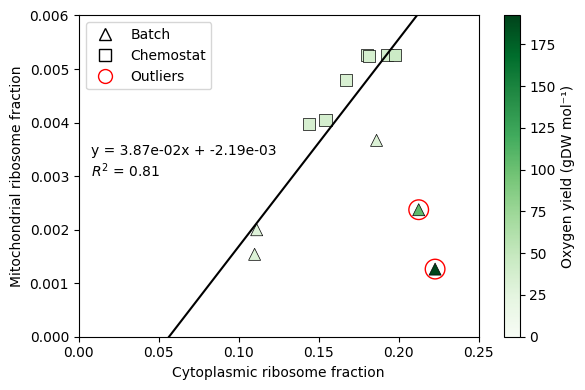

In [2]:
# ============================================================
# FIGURE 2 — Cytoplasmic vs mitochondrial ribosomes (RANSAC)
# ============================================================

# -----------------------------
# 1. Fit RANSAC (with identification of outliers)
# -----------------------------
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    residual_threshold=0.002)

ransac.fit(rc, rm)
inliers = ransac.inlier_mask_
outliers = ~inliers

# -----------------------------
# 2. Regression line
# -----------------------------
xmin = 0.0
xmax = rc.max()

line_x = np.linspace(xmin, xmax, 200).reshape(-1, 1)
line_y = ransac.predict(line_x)

# Retrieve slope (a) and intercept (b)
a = ransac.estimator_.coef_[0]        # slope
b = ransac.estimator_.intercept_      # intercept

# Predict values using the RANSAC model
y_pred = ransac.predict(rc)

# Compute R² using only the inliers 
R2 = r2_score(rm[inliers], y_pred[inliers])

# -----------------------------
# 3. Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 4))

def scatter_group(x, y, color_all, idx, marker):
    """
    Scatter of one group (chemostat or batch).
    """
    xg = x[idx]
    yg = y[idx]
    cg = color_all[idx]

    inl = inliers[idx]
    outl = outliers[idx]

    # Inliers
    sc = ax.scatter(
        xg[inl], yg[inl], c=cg[inl],
        cmap="Greens", vmin=0, vmax=max(Yield),
        s=75, marker=marker,
        edgecolors="black", linewidths=0.5)

    # Outliers (normal marker)
    ax.scatter(
        xg[outl], yg[outl], c=cg[outl],
        cmap="Greens", vmin=0, vmax=max(Yield),
        s=75, marker=marker,
        edgecolors="black", linewidths=0.5)

    # Outlier red halo
    ax.scatter(
        xg[outl], yg[outl],
        facecolors="none", edgecolors="red",
        linewidths=1, s=200, marker="o")

    return sc

# -----------------------------
# 4. Scatter all points
# -----------------------------

# Chemostat (squares)
sc = scatter_group(
    rc[:, 0], rm, Yield,
    chemo_idx, marker="s")

# Batch (triangles)
scatter_group(
    rc[:, 0], rm, Yield,
    batch_idx, marker="^")

# -----------------------------
# 5. Colorbar and regression line
# -----------------------------
plt.colorbar(sc, label="Oxygen yield (gDW mol⁻¹)")

ax.plot(line_x, line_y, "k-", linewidth=1.5)

# Equation
eq = f"y = {a:.2e}x + {b:.2e}\n$R^2$ = {R2:.2f}"
plt.text(0.03, 0.6, eq, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')  


# -----------------------------
# 6. Axis formatting
# -----------------------------
ax.set_xlabel("Cytoplasmic ribosome fraction")
ax.set_ylabel("Mitochondrial ribosome fraction")
ax.set_xlim(0, 0.25)
ax.set_ylim(0, 0.006)

# -----------------------------
# 7. Legend
# -----------------------------
legend_batch = mlines.Line2D(
    [], [], marker="^", color="black",
    linestyle="None", markersize=8,
    markerfacecolor="white", markeredgecolor="black",
    label="Batch")

legend_chemo = mlines.Line2D(
    [], [], marker="s", color="black",
    linestyle="None", markersize=8,
    markerfacecolor="white", markeredgecolor="black",
    label="Chemostat")

legend_outlier = mlines.Line2D(
    [], [], marker="o", color="red",
    linestyle="None", markersize=10,
    markerfacecolor="white", markeredgecolor="red",
    label="Outliers")

ax.legend(
    handles=[legend_batch, legend_chemo, legend_outlier],
    frameon=True)

plt.tight_layout()
plt.savefig("Fig2_cyto_vs_mito.eps", dpi=300)
plt.show()